



#Media Bias on Twitter using Sentiment Analysis [BERT]

The folllowing notebook trains a Sentiment Classifier on the [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction) dataset available on Kaggle. We'll use the pretrained BERT  model for Sentiment analysis from [Hugging face](https://huggingface.co/transformers/model_doc/bert.html) library.


I have scrapped the data from the twitter accounts of four English News Channels of India CNN News18, Republic TV, NDTV, Times Now. We'll predict the sentiment of these tweets and analyse how one channel is biased towards any particular political party or leaders.


##Table of Contents:
>1. [Setup](#setup)
>2. [Data Preparation](#prep)
>3. [Model](#mod)
>4. [Training](#train)
>5. [Evaluation](#eval)
>6. [Sentiment Prediction](#sent)
>7. [Analysis of media-bias](#ana)


#<a id="setup">Setup</a>

In [ ]:
!pip install transformers


In [ ]:
import numpy as np 
import pandas as pd 
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("cpu")


#<a id="prep">Data Preparation</a>

In [ ]:
train = pd.read_csv("train.csv")
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


The dataset contains selected_text and sentiment but we will use only sentiment column and text column for training purpose.

In [ ]:
test = pd.read_csv("test.csv")
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


Converting the sentiment values to integers:-


* neutral - 1

* positive - 2

* negative - 0

In [ ]:
#Removing missing values
train['text'].dropna(axis=0,inplace=True)
train['sentiment'].dropna(axis=0,inplace=True)

#Replacing sentiments with scores
train['sentiment'].replace({'neutral':1,'positive':2,'negative':0},inplace=True)


In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,088c60f138,my boss is bullying me...,bullying me,0
3,9642c003ef,what interview! leave me alone,leave me alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0


In [ ]:
#Removing missing values
test['text'].dropna(axis=0,inplace=True)
test['sentiment'].dropna(axis=0,inplace=True)

#Replacing sentiments with scores
test['sentiment'].replace({'neutral':1,'positive':2,'negative':0},inplace=True)

In [ ]:
MAX_LEN=160
classes = ['negative', 'neutral', 'positive']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class TwitterDataset(Dataset):
#Creating a Twitter sentiment dataset
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.reviews)  
  
  def __getitem__(self, item):
    review = str(self.reviews[item]) #tweet
    target = self.targets[item] #sentiment
    
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True, # addding [CLS] and [SEP] tokens
      max_length=self.max_len,
      return_token_type_ids=False,
      truncation=True, #trunction for max length
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt', #PyTorch tensors
    )
 
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Splitting the training and testing data

In [ ]:
d_train, d_test = train_test_split(
  train,
  test_size=0.1,
  random_state=RANDOM_SEED
)
d_val, d_test = train_test_split(
  test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
def dataloader(dataframe, tokenizer, max_len, batch_size):
#dataloader for pytorch dataset

  dataset = TwitterDataset(
    reviews = dataframe.text.to_numpy(), #converting to numpy array
    targets = dataframe.sentiment.to_numpy(),  #converting to numpy array
    max_len=max_len, # setting the maximum length
    tokenizer=tokenizer,
    
  )

  return DataLoader(
    dataset,
    num_workers=4,
    batch_size=batch_size,
  )


In [ ]:
BATCH_SIZE = 16
train_dataloader = dataloader(d_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = dataloader(d_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = dataloader(d_test, tokenizer, MAX_LEN, BATCH_SIZE)

#<a id='mod'>Model</a>

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')


In [ ]:
class Classifier(nn.Module):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    #using only [CLS] embedding, ignoring sequence output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
data = next(iter(train_dataloader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
model = Classifier(len(classes))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

#<a id="train">Training</a>

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_dataloader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(d_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_dataloader,
    loss_fn,
    device,
    len(d_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.5732372517795103 accuracy 0.7666990134239042
Val   loss 0.5030230187081002 accuracy 0.7911714770797963

Epoch 2/3
----------
Train loss 0.3726332970276803 accuracy 0.861475012130034
Val   loss 0.5425045691631936 accuracy 0.7973967176004528

Epoch 3/3
----------
Train loss 0.26522581035664056 accuracy 0.9097525473071325
Val   loss 0.6699393585928388 accuracy 0.7911714770797963

CPU times: user 21min 38s, sys: 14min 53s, total: 36min 31s
Wall time: 36min 43s


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_dataloader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    negative       0.77      0.82      0.79       484
     neutral       0.78      0.75      0.77       720
    positive       0.84      0.84      0.84       563

    accuracy                           0.80      1767
   macro avg       0.80      0.80      0.80      1767
weighted avg       0.80      0.80      0.80      1767



#<a id="sent">Sentiment Prediction<a>

I have used the [Twitter Scrapper](https://dev.to/natterstefan/scrape-tweets-from-twitter-profiles-without-using-twitter-s-api-47n7) for scraping the latest 5000 tweets of every channel.

---



In [ ]:
df = pd.read_csv("tweets.csv",index_col=[0])
df.head()

,channel,tweet,Modi,Rahul Gandhi,BJP,Congress,Amit Shah,Arvind Kejriwal
0,ndtv,"""Aggrieved"": Rahul Gandhi says ""regret police ...",0,1,0,0,0,0
1,ndtv,"UK plans local #lockdowns, Indian-origin peopl...",0,0,0,0,0,0
2,ndtv,"Bengal didn't share data, missed migrants job ...",0,0,0,0,0,0
3,ndtv,"Gurugram shopping malls to reopen from July 1,...",0,0,0,0,0,0
4,ndtv,UP starting MBBS classes can jeopardise studen...,0,1,0,0,0,0


**Data Description**
>1. channel - Name of the news channel.
>2. tweet   - Text of the tweet.
>3.Modi     - Tweet contains keyword 'modi' or not
>3.Rahul Gandhi     - Tweet contains keyword 'Rahul Gandhi' or not
>3.BJP     - Tweet contains keyword 'BJP' or not
>3.Congress     - Tweet contains keyword 'Congress' or not
>3.Amit Shah     - Tweet contains keyword 'Amit Shah' or not
>3.Arvind Kejriwal     - Tweet contains keyword 'Arvind Kejriwal' or not

In [ ]:
pred = []
for tweet in df['tweet']:
  encoded_review = tokenizer.encode_plus(
  tweet,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  pred.append(classes[prediction])

df['sentiment'] = pred


Creating a new column 'relevant', it will be 1 or 0 depending upon whether it contains any keywords or not

In [ ]:
df['relevant']=df.sum(axis=1)
binary=[]
for t in df['relevant']:
  if t>0:
    binary.append(1)
  else:
    binary.append(0)



In [ ]:
df['relevant'] =binary
df.head()

,channel,tweet,Modi,Rahul Gandhi,BJP,Congress,Amit Shah,Arvind Kejriwal,sentiment,relevant
0,ndtv,"""Aggrieved"": Rahul Gandhi says ""regret police ...",0,1,0,0,0,0,negative,1
1,ndtv,"UK plans local #lockdowns, Indian-origin peopl...",0,0,0,0,0,0,negative,0
2,ndtv,"Bengal didn't share data, missed migrants job ...",0,0,0,0,0,0,negative,0
3,ndtv,"Gurugram shopping malls to reopen from July 1,...",0,0,0,0,0,0,neutral,0
4,ndtv,UP starting MBBS classes can jeopardise studen...,0,1,0,0,0,0,negative,1


#<a id="ana">Analysis of Media-Bias<a>

In [ ]:
num_relevant = df.relevant.sum()
num_total = df.shape[0]
print('Number of relevant tweets: %s' % num_relevant)
print('Total number of tweets: %s' % num_total)
print('Percentage of relevant tweets: %0.2f%%' % (100*num_relevant/num_total))

Number of relevant tweets: 3408
Total number of tweets: 20000
Percentage of relevant tweets: 17.04%


The chosen topics are covered in of the total 20,000 tweets. Let's see to what extent those topics are covered overall by each channel

In [ ]:
channel_stats = pd.DataFrame({
    'relevant': df.groupby('channel').relevant.sum().astype(int),
    'total': df.groupby('channel').size()
})
channel_stats['percentage_relevant'] = (100*channel_stats.relevant/channel_stats.total).round(2)
channel_stats.sort_values('percentage_relevant', ascending=False)

,relevant,total,percentage_relevant
channel,,,
times,1163,5000,23.26
cnn,849,5000,16.98
ndtv,814,5000,16.28
republic,582,5000,11.64


##Relative topic Coverage
> It shows that how important each topic is to each channel, We will plot the count of tweets about every topic for each channel.

Text(0.5, 1.0, 'Rahul Gandhi')

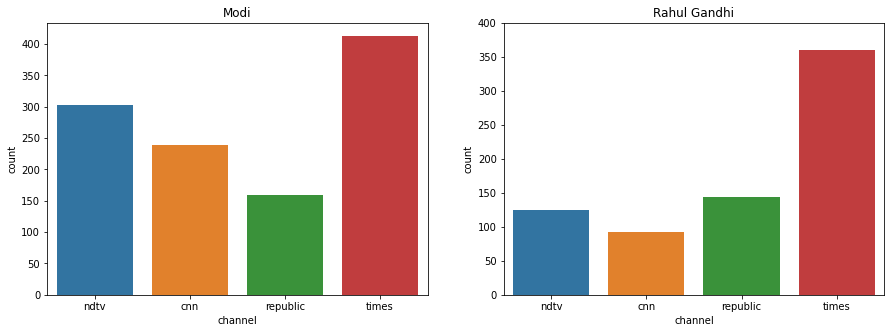

In [ ]:
modi=df.loc[df['Modi'] == 1]
rahul_gandhi=df.loc[df['Rahul Gandhi'] == 1]

fig, axes = plt.subplots(1, 2,figsize=(15,5))
plt.ylim(0, 400)
sns.countplot(x="channel", data=modi, ax=axes[0]).set_title("Modi")
sns.countplot(x='channel',data=rahul_gandhi, ax=axes[1]).set_title("Rahul Gandhi")


It shows that except the Times now news Channel the other three talks more about Narendra Modi than Rahul Gandhi.

Text(0.5, 1.0, 'Congress')

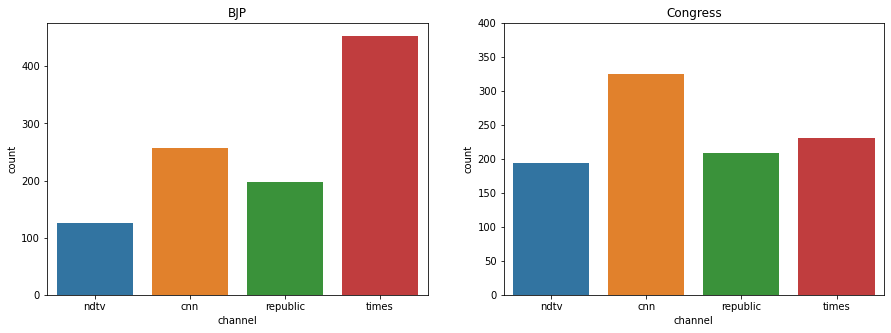

In [ ]:
bjp=df.loc[df['BJP'] == 1]
congress=df.loc[df['Congress'] == 1]

fig, axes = plt.subplots(1, 2,figsize=(15,5))
plt.ylim(0, 400)
sns.countplot(x="channel", data=bjp, ax=axes[0]).set_title("BJP")
sns.countplot(x='channel',data=congress, ax=axes[1]).set_title("Congress")


* It can be seen from the above graph that Times Now is having the most tweets about BJP(and Modi) than any other channel and 
*For Congress Party the distribution is nearly equal among all channels with CNN having the maximum tweets about Congress Party.

Text(0.5, 1.0, 'Arvind Kejriwal')

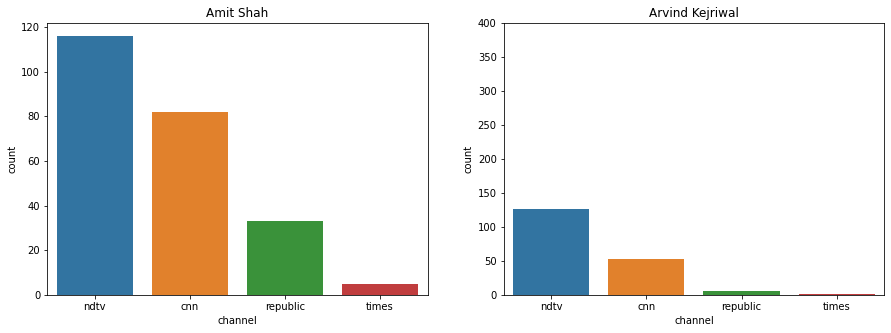

In [ ]:
amit=df.loc[df['Amit Shah'] == 1]
arvind=df.loc[df['Arvind Kejriwal'] == 1]

fig, axes = plt.subplots(1, 2,figsize=(15,5))
plt.ylim(0, 400)
sns.countplot(x="channel", data=amit, ax=axes[0]).set_title("Amit Shah")
sns.countplot(x='channel',data=arvind, ax=axes[1]).set_title("Arvind Kejriwal")

It shows that NDTV talks about BJP's Political Leaders quite often and Arwind Kejriwal is having very few tweets on all the four channels.

##Sentiment towards Topics

We will show the sentiments of News Channels towards our Topics by ploting percentage of their positive tweets and negative tweets out of their total tweets about a topic.

### Percentage Positive Tweets

In [ ]:
modi.groupby(['channel','sentiment']).sum()

Modi  Rahul Gandhi  ...  Arvind Kejriwal  relevant
channel  sentiment                      ...                           
cnn      negative     31            11  ...                0        31
         neutral     165            15  ...                1       165
         positive     43             1  ...                0        43
ndtv     negative     24             4  ...                0        24
         neutral     193            14  ...                0       193
         positive     86             5  ...                0        86
republic negative     28             9  ...                0        28
         neutral     112            10  ...                0       112
         positive     19             0  ...                0        19
times    negative    109            28  ...                0       109
         neutral     232            20  ...                0       232
         positive     72             0  ...                0        72

[12 rows x 7 columns]

In [ ]:
channels=['cnn','ndtv','republic','times']


**Modi vs Rahul Gandhi**

Text(0.5, 1.0, 'Rahul Gandhi')

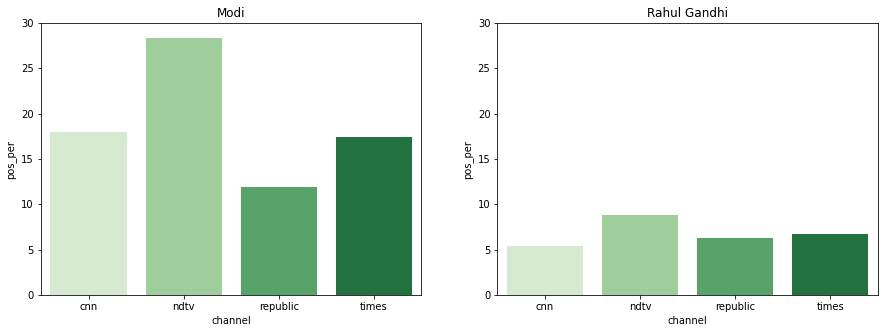

In [ ]:
groups = modi.groupby(['channel','sentiment'])
group = modi.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('cnn','positive')))/len(group.get_group('cnn')))
a.append(100*len(groups.get_group(('ndtv','positive')))/len(group.get_group('ndtv')))
a.append(100*len(groups.get_group(('republic','positive')))/len(group.get_group('republic')))
a.append(100*len(groups.get_group(('times','positive')))/len(group.get_group('times')))


groups = rahul_gandhi.groupby(['channel','sentiment'])
group = rahul_gandhi.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('cnn','positive')))/len(group.get_group('cnn')))
b.append(100*len(groups.get_group(('ndtv','positive')))/len(group.get_group('ndtv')))
b.append(100*len(groups.get_group(('republic','positive')))/len(group.get_group('republic')))
b.append(100*len(groups.get_group(('times','positive')))/len(group.get_group('times')))

fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,30)
axes[1].set_ylim(0,30)

d=pd.DataFrame({'channel':channels,'pos_per':a})
e=pd.DataFrame({'channel':channels,'pos_per':b})


sns.barplot(x='channel',y='pos_per',data=d,ax=axes[0], palette=("Greens")).set_title("Modi")
sns.barplot(x='channel',y='pos_per',data=e,ax=axes[1], palette=("Greens")).set_title("Rahul Gandhi")






* It shows that all the four News Channel talks more positive about Narendra Modi than Rahul Gandhi
* NDTV is having the maximum positive tweets percent of 28.38%.
* Rahul Gandhi is having very few positive tweets from all the four channels.
* Combined positive percentage of Rahul Gandhi ( 5.43 + 8.8 + 6.25 + 6.66 ) is less than NDTV's ( 28.38 %) for Narendra Modi.


**BJP vs Congress**

Text(0.5, 1.0, 'Congress')

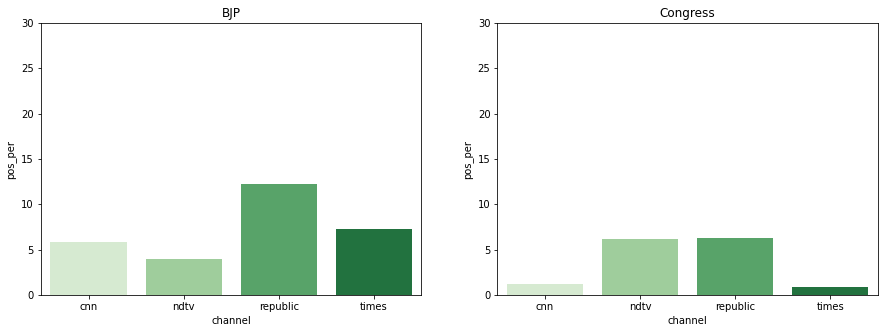

In [ ]:
groups = bjp.groupby(['channel','sentiment'])
group = bjp.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('cnn','positive')))/len(group.get_group('cnn')))
a.append(100*len(groups.get_group(('ndtv','positive')))/len(group.get_group('ndtv')))
a.append(100*len(groups.get_group(('republic','positive')))/len(group.get_group('republic')))
a.append(100*len(groups.get_group(('times','positive')))/len(group.get_group('times')))


groups = congress.groupby(['channel','sentiment'])
group = congress.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('cnn','positive')))/len(group.get_group('cnn')))
b.append(100*len(groups.get_group(('ndtv','positive')))/len(group.get_group('ndtv')))
b.append(100*len(groups.get_group(('republic','positive')))/len(group.get_group('republic')))
b.append(100*len(groups.get_group(('times','positive')))/len(group.get_group('times')))

fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,30)
axes[1].set_ylim(0,30)

d=pd.DataFrame({'channel':channels,'pos_per':a})
e=pd.DataFrame({'channel':channels,'pos_per':b})


sns.barplot(x='channel',y='pos_per',data=d,ax=axes[0], palette=("Greens")).set_title("BJP")
sns.barplot(x='channel',y='pos_per',data=e,ax=axes[1], palette=("Greens")).set_title("Congress")

* It can be seen that the News Channels are more interested in any particular leader than a party, because for both BJP and Congress the percent of positive tweets is less.
* Republic TV having more positive tweets about BJP party.

###Percentage Negative Tweets

**Modi vs Rahul Gandhi**

Text(0.5, 1.0, 'Rahul Gandhi')

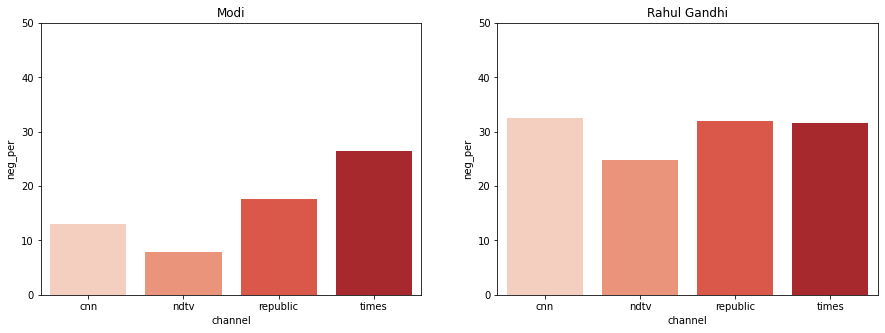

In [ ]:
groups = modi.groupby(['channel','sentiment'])
group = modi.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('cnn','negative')))/len(group.get_group('cnn')))
a.append(100*len(groups.get_group(('ndtv','negative')))/len(group.get_group('ndtv')))
a.append(100*len(groups.get_group(('republic','negative')))/len(group.get_group('republic')))
a.append(100*len(groups.get_group(('times','negative')))/len(group.get_group('times')))


groups = rahul_gandhi.groupby(['channel','sentiment'])
group = rahul_gandhi.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('cnn','negative')))/len(group.get_group('cnn')))
b.append(100*len(groups.get_group(('ndtv','negative')))/len(group.get_group('ndtv')))
b.append(100*len(groups.get_group(('republic','negative')))/len(group.get_group('republic')))
b.append(100*len(groups.get_group(('times','negative')))/len(group.get_group('times')))

fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,50)
axes[1].set_ylim(0,50)

d=pd.DataFrame({'channel':channels,'neg_per':a})
e=pd.DataFrame({'channel':channels,'neg_per':b})


sns.barplot(x='channel',y='neg_per',data=d,ax=axes[0], palette=("Reds")).set_title("Modi")
sns.barplot(x='channel',y='neg_per',data=e,ax=axes[1], palette=("Reds")).set_title("Rahul Gandhi")






* We can see clearly in the above figure that the all the News channels talks so much negative about Rahul Gandhi.
* But for Narendra Modi that is not the case, only Republic TV is having a significant negative percent and rest all are below 20%.

**BJP vs Congress**

Text(0.5, 1.0, 'Congress')

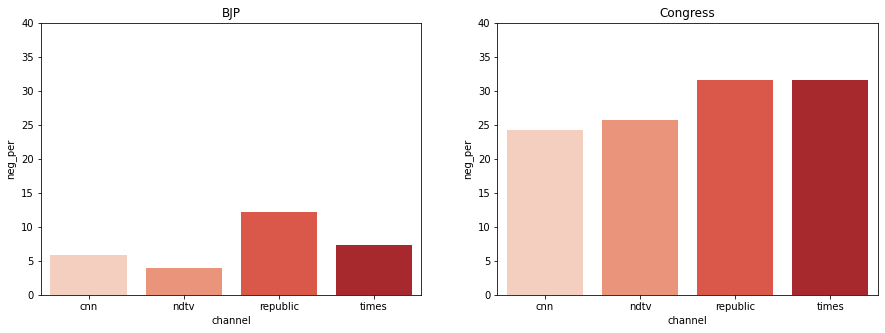

In [ ]:
groups = bjp.groupby(['channel','sentiment'])
group = bjp.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('cnn','positive')))/len(group.get_group('cnn')))
a.append(100*len(groups.get_group(('ndtv','positive')))/len(group.get_group('ndtv')))
a.append(100*len(groups.get_group(('republic','positive')))/len(group.get_group('republic')))
a.append(100*len(groups.get_group(('times','positive')))/len(group.get_group('times')))


groups = congress.groupby(['channel','sentiment'])
group = congress.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('cnn','negative')))/len(group.get_group('cnn')))
b.append(100*len(groups.get_group(('ndtv','negative')))/len(group.get_group('ndtv')))
b.append(100*len(groups.get_group(('republic','negative')))/len(group.get_group('republic')))
b.append(100*len(groups.get_group(('times','negative')))/len(group.get_group('times')))


fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,40)
axes[1].set_ylim(0,40)

d=pd.DataFrame({'channel':channels,'neg_per':a})
e=pd.DataFrame({'channel':channels,'neg_per':b})


sns.barplot(x='channel',y='neg_per',data=d,ax=axes[0], palette=("Reds")).set_title("BJP")
sns.barplot(x='channel',y='neg_per',data=e,ax=axes[1], palette=("Reds")).set_title("Congress")

* Here also BJP is having very low percent of negative tweets from all the channels.
* Congress is not so popular among these channels becuse ever channel is having about 25% negative tweets which is very low than that of BJP.
* We can also see that for BJP most of the tweets are neutral (because both the positive and negative count is low).

#<a id="ref"> References</a>

* [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

* [Hugging Face Transformers](https://huggingface.co/transformers/)

* [Text Classification | Sentiment Analysis with BERT using huggingface](https://www.youtube.com/watch?time_continue=2055&v=8N-nM3QW7O0&feature=emb_title)

* [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
